In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf 6864-hw2b

In [ ]:
import os
os.makedirs("6864-hw2b", exist_ok=True)
import sys
sys.path.append("/content/6864-hw2b")

In [ ]:
!pip install sacrebleu

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 17.1MB 197kB/s 


# **Part 3: Sequence-to-Sequence Model**



In this lab, you will explore RNN-based sequence-to-sequence (seq2seq) models to perform machine translation (MT). We will use a Vietnamese-English dataset from IWSLT'15. The task is to translate a Vietnamese sentence into English.

The lab is divided into two parts. The first part is to implement a vanilla seq2seq architecture without attention. In the second part you will implement your favorite attention mechanism (doesn't have to come from lecture) and add it to your vanilla seq2seq model. We will provide the training and testing scripts (trust me, the decoding/testing is actually the hardest part :P), so you will mainly just have to focus on implementing the models (I say *mainly* because you still might need to modify the testing script, depending on which attention method you use and how you implement it).


## **Section 1: Data Preprocessing**

No need to write any code in this section. But you are encouraged to test with this part to understand the data.

First, we download the dataset and place it under current directory.

In [ ]:
# Download data
!wget -nv -O /content/6864-hw2b/train.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget -nv -O /content/6864-hw2b/train.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget -nv -O /content/6864-hw2b/tst2013.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget -nv -O /content/6864-hw2b/tst2013.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi
!wget -nv -O /content/6864-hw2b/vocab.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
!wget -nv -O /content/6864-hw2b/vocab.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi

2020-04-01 02:45:25 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en [13603614/13603614] -> "/content/6864-hw2b/train.en" [1]
2020-04-01 02:45:26 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi [18074646/18074646] -> "/content/6864-hw2b/train.vi" [1]
2020-04-01 02:45:27 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en [132264/132264] -> "/content/6864-hw2b/tst2013.en" [1]
2020-04-01 02:45:28 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi [183855/183855] -> "/content/6864-hw2b/tst2013.vi" [1]
2020-04-01 02:45:29 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en [139741/139741] -> "/content/6864-hw2b/vocab.en" [1]
2020-04-01 02:45:30 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi [46767/46767] -> "/content/6864-hw2b/vocab.vi" [1]


Next, we do some simple data preprocessing and show some data statistics.

Number of training (src, trg) sentence pairs: 28794
Number of validation (src, trg) sentence pairs: 3199
Number of testing (src, trg) sentence pairs: 250
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 7710
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 17192
Training sentence avg. length: 16 
Training sentence length at 95-percentile: 20
Training sentence length distribution (x-axis is length range and y-axis is count):



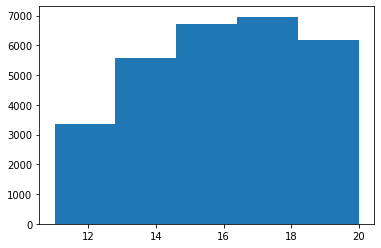

Example Vietnamese input: ['ZK', ':', 'Đây', 'là', 'Steve', '.', 'Được', 'rồi', 'Steve', ',', 'bây', 'giờ', 'đi', 'theo', 'tôi', 'nhé', '.']
Its target English output: ['ZK', ':', 'It', '&apos;s', 'Steve', '.', 'All', 'right', 'Steve', ',', 'now', ',', 'follow', 'me', '.']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def read_sentence_file(filename):
  sentences_list = []
  with open(filename, "r") as f:
    for line in f:
      sentences_list.append(line.strip().split())
  return sentences_list

def read_vocab_file(filename):
  with open(filename, "r") as f:
    return [line.strip() for line in f]


src_vocab_set = read_vocab_file(os.path.join("/content/6864-hw2b", "vocab.vi"))
trg_vocab_set = read_vocab_file(os.path.join("/content/6864-hw2b", "vocab.en"))

train_src_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                           "train.vi"))
train_trg_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                           "train.en"))
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

test_src_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                          "tst2013.vi"))
test_trg_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                          "tst2013.en"))
assert len(test_src_sentences_list) == len(test_trg_sentences_list)


MAX_SENT_LENGTH = 48
MAX_SENT_LENGTH_PLUS_SOS_EOS = 50
max_sent_length_define = 20
min_sent_length_define = 10

# We only keep sentences that do not exceed 48 words, so that later when we
# add <s> and </s> to a sentence it still won't exceed 50 words.
def filter_data(src_sentences_list, trg_sentences_list, max_len, min_len):
  new_src_sentences_list, new_trg_sentences_list = [], []
  for src_sent, trg_sent in zip(src_sentences_list, trg_sentences_list):
    if (len(src_sent) <= max_len and len(trg_sent) <= max_len
        and len(src_sent) > min_len and len(trg_sent)) > min_len:
      new_src_sentences_list.append(src_sent)
      new_trg_sentences_list.append(trg_sent)
  return new_src_sentences_list, new_trg_sentences_list

max_len = max_sent_length_define
min_len = min_sent_length_define
train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, train_trg_sentences_list, max_len, min_len)
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, test_trg_sentences_list, max_len, min_len)

# We take 10% of training data as validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

# Show some data stats
print("Number of training (src, trg) sentence pairs: %d" %
      len(train_src_sentences_list))
print("Number of validation (src, trg) sentence pairs: %d" %
      len(val_src_sentences_list))
print("Number of testing (src, trg) sentence pairs: %d" %
      len(test_src_sentences_list))
src_vocab_set = ['<pad>'] + src_vocab_set
trg_vocab_set = ['<pad>'] + trg_vocab_set
print("Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(src_vocab_set))
print("Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(trg_vocab_set))

length = [len(sent) for sent in train_src_sentences_list]
print('Training sentence avg. length: %d ' % np.mean(length))
print('Training sentence length at 95-percentile: %d' %
      np.percentile(length, 95))
print('Training sentence length distribution '
      '(x-axis is length range and y-axis is count):\n')
plt.hist(length, bins=5)
plt.show()

print('Example Vietnamese input: ' + str(train_src_sentences_list[0]))
print('Its target English output: ' + str(train_trg_sentences_list[0]))

Here we define a class called `MTDataset`. It is built on top of the efficient data loader API provided in PyTorch. See Section 5 for explanation.

In [ ]:
import torch
from torch.utils import data

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# These IDs are reserved.
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3


class MTDataset(data.Dataset):
  def __init__(self, src_sentences, src_vocabs, trg_sentences, trg_vocabs,
               sampling=1.):
    self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
    self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]

    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
    self.max_trg_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

    self.src_vocabs = src_vocabs
    self.trg_vocabs = trg_vocabs

    self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
    self.src_id2v = {val : key for key, val in self.src_v2id.items()}
    self.trg_v2id = {v : i for i, v in enumerate(trg_vocabs)}
    self.trg_id2v = {val : key for key, val in self.trg_v2id.items()}

  def __len__(self):
    return len(self.src_sentences)

  def __getitem__(self, index):
    src_sent = self.src_sentences[index]
    src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
    src_id = []
    for w in src_sent:
      if w not in self.src_vocabs:
        w = '<unk>'
      src_id.append(self.src_v2id[w])
    src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_src_seq_length - src_len))

    trg_sent = self.trg_sentences[index]
    trg_len = len(trg_sent) + 2
    trg_id = []
    for w in trg_sent:
      if w not in self.trg_vocabs:
        w = '<unk>'
      trg_id.append(self.trg_v2id[w])
    trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_trg_seq_length - trg_len))

    return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len

## **Section 2: Encoder**

Seq2seq consists of an Encoder RNN and a decoder RNN. In a vanilla seq2seq model where there is no attention mechanism between encoder and decoder, the encoder aims to compress the information contained in the entire input sequence into a single vector and pass it to decoder.

We start with implementing the encoder, which is just a simple RNN. We use a GRU here, but feel free to try other cell types.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers = 1, bidirection = False, dropout=0.):
    """
    Inputs: 
      - `input_size`: an int representing the RNN input size.
      - `hidden_size`: an int representing the RNN hidden size.
      - `dropout`: a float representing the dropout rate during training. Note
          that for 1-layer RNN this has no effect since dropout only applies to
          outputs of intermediate layers.
    """
    
    super(Encoder, self).__init__()
    # Note: for lab writeup question #4, you can directly change `num_layers`
    # and `bidirectional` here to enable deep/bidirectional RNNs. However, you
    # will also need to modify some parts in the rest of the code accordingly.
    
    self.bidirection = bidirection
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True,
                      dropout=dropout, bidirectional=self.bidirection)
    self.bi_linear = nn.Linear(2*hidden_size, hidden_size)
    self.drop = nn.Dropout(dropout)
    
  def forward(self, inputs, lengths):
    """
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of source
          sentences.
      - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence
          lengths of `inputs`.

    Returns:
      - `outputs`: a 3d-tensor of shape
        (batch_size, max_seq_length, hidden_size).
      - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).
      Hint: `outputs` and `finals` are both standard GRU outputs. Check:
      https://pytorch.org/docs/stable/nn.html#gru
    """
    pack_pad = pack_padded_sequence(self.drop(inputs), lengths, batch_first=True, enforce_sorted=False)
    ### Your code here!
    outputs, finals = self.gru(pack_pad)
    outputs, _ = pad_packed_sequence(outputs, batch_first=True, total_length = inputs.size(1))
    
    if self.bidirection:
        forward = finals[0:list(finals.size())[0]:2]
        backward = finals[1:list(finals.size())[0]:2]
        finals = torch.cat([forward, backward], dim=2)
        finals = self.bi_linear(finals)
        outputs = self.bi_linear(outputs)
        
    return outputs, finals

## **Section 3: Decoder**

Here you will implement a decoder RNN that uses encoder's last hidden state to initialize its initial hidden state.

In [ ]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, num_layers = 1, feed_ratio = 0.5, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(Decoder, self).__init__()

    ### Your code here!
    self.hidden_size = hidden_size
    self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.input_hidden = nn.Linear(input_size, hidden_size)
    self.feed_ratio = feed_ratio
    
  def forward(self, inputs, encoder_finals, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.

    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
          We will convert it later in a `Generator` below.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the last decoder hidden state.
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    #outputs = None
    ### Your code here!
    
    outputs = []
    for i in range(max_len):
        if i == 0:
            embed_input = self.input_hidden(F.relu(inputs[:,i,:].unsqueeze(1)))
            output, hidden = self.gru(embed_input, hidden)
        else:
            feed_target = True if random.random() < self.feed_ratio else False
            if feed_target:
                embed_input = self.input_hidden(F.relu(inputs[:,i,:].unsqueeze(1)))
            else:
                embed_input = output
            
            output, hidden = self.gru(embed_input, hidden)
            
        outputs.append(output)
    
    outputs = torch.cat(outputs, dim = 1)
    
    return hidden, outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    ### Your code here!
    if encoder_finals != None:
        return torch.tanh(encoder_finals)
    else:
        return None

Define the high level encoder-decoder class to wrap up sub-models, including encoder, decoder, generator, and src/trg embeddings.

In [ ]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `Decoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    del encoder_hiddens   # unused
    return self.decode(encoder_finals, trg_ids[:, :-1])

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)

It simply projects the pre-output layer (x in the forward function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [ ]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

## **Section 4: Attention-Based Decoder**

Now it's time to add some attention to the decoder. You can implement any attention mechanism you want.


In [ ]:
class BahAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.q_weight = nn.Linear(hidden_size, hidden_size, bias=False)
        self.k_weight = nn.Linear(hidden_size, hidden_size, bias=False)
        self.va = nn.Linear(hidden_size, 1, bias=False)
        self.att_weight = None
        
    def forward(self, q, k, v, mask):
        #q = q.unsqueeze(1)
        #q_linear = nn.Linear(q.size(2), self.hidden_size).cuda()
        #k_linear = nn.Linear(k.size(2), self.hidden_size).cuda()
        #print(list(q_p.size()))
        #k_p = self.k_weight(k)
        #print(list(k.size()))
        combine = torch.tanh(self.q_weight(q) + self.k_weight(k))
        energy = self.va(combine).squeeze(2).unsqueeze(1)
        energy.data.masked_fill_(mask == False, -float('inf'))
        att_weight = F.softmax(energy, dim=-1)
        self.att_weight = att_weight
        context = att_weight.bmm(v)
        return context

'''
AttentionDecoder
'''

class AttentionDecoder(nn.Module):
  """An attention-based RNN decoder."""

  def __init__(self, input_size, hidden_size, attention, num_layers, feed_ratio = 0.5, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
        - `attention`: this is your self-defined Attention object. You can
            either define an individual class for your Attention and pass it
            here or leave `attention` as None and just implement everything
            here.
    """
    super(AttentionDecoder, self).__init__()

    ### Your code here!
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.dropout = dropout
    self.feed_ratio = feed_ratio

    self.attention = attention
    self.input_hidden = nn.Linear(input_size, hidden_size)
    self.lstm = nn.LSTM(hidden_size*2, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.drop_layer = nn.Dropout(dropout)
    self.output1 = nn.Linear(hidden_size, hidden_size)
    self.output2 = nn.Linear(hidden_size*3, hidden_size)

    
  def forward(self, inputs, encoder_hiddens, encoder_finals,  src_mask,
              hidden=None, trg_mask = None, max_len=None):
    """Unroll the decoder one step at a time.
    
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_hiddens`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the encoder
          outputs for each decoding step to attend to. 
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `src_mask`: a 3d-tensor of shape (batch_size, 1, max_seq_length)
          representing the mask for source sentences.
      - `trg_mask`: a 3d-tensor of shape (batch_size, 1, max_seq_length)
          representing the mask for target sentences.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: (same as in Decoder) a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the last decoder hidden state.
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    if hidden is None:
      #print('encoder final')
      #print(encoder_finals.size())
      hidden = self.init_hidden(encoder_finals)

    #outputs = None
    ### Your code here!
    
    #print('input')
    #print(inputs.size())
    #print(self.input_size)
    #print('max_len: ' + str(max_len))

    outputs = []
    for i in range(max_len):
        #print(hidden[-1].size())
        #print(hidden[-1].unsqueeze(1).size())
        context = self.attention(hidden[-1].unsqueeze(1), encoder_hiddens, encoder_hiddens, src_mask)
        if i == 0:
            embed_input = self.input_hidden(inputs[:,i,:].unsqueeze(1))
            lstm_input = torch.cat([context, self.drop_layer(embed_input)], dim = -1)
            #print('hidden size')
            #print(hidden[0].size())
            output, (hidden, cell) = self.lstm(lstm_input, (hidden, hidden))
            
        else:
            feed_target = True if random.random() < self.feed_ratio else False
            if feed_target:
                embed_input = self.input_hidden(inputs[:,i,:].unsqueeze(1))
            else:
                embed_input = output
            
            lstm_input = torch.cat([context, self.drop_layer(embed_input)], dim = -1)
            #print('hidden size')
            #print(hidden.size())
            output, (hidden, cell) = self.lstm(lstm_input, (hidden, hidden))
            
        
        result1 = self.output1(output + context)
        #result2 = self.output2(torch.cat([output, context, embed_input]), dim = -1)
        outputs.append(result1)
        #outputs.append(result2)
    
    outputs = torch.cat(outputs, dim = 1)
    
    return hidden, outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    #decoder_init_hiddens = None
    ### Your code here!
    
    if encoder_finals != None:
        return torch.tanh(encoder_finals)
    else:
        return None

Similarly, we use a `EncoderAttentionDecoder` class to wrap up all encoder, decoder, src/trg embeddings, and generator. You can take the `EncoderDecoder` class as a reference.

In [ ]:
class EncoderAttentionDecoder(nn.Module):
  """A Encoder-Decoder architecture with attention.
  """
  def __init__(self, encoder, decoder, src_embed , trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `AttentionDecoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderAttentionDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and tar get sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    ### Your code here!
    # You can refer to `EncoderDecoder` and extend from it.
    src_mask = (src_ids != 0).unsqueeze(1)
    #print(src_ids.size())
    #print(src_mask.size())
    encoder_output, encoder_finals = self.encode(src_ids, src_lengths)
    #print('output')
    #print(encoder_output.size())
    return self.decode(encoder_finals, encoder_output, trg_ids[:, :-1], src_mask)
    
  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, encoder_hiddens, trg_ids, src_mask, decoder_hidden=None):
    #print(trg_ids.size())
    #print(src_mask.size())
    return self.decoder(self.trg_embed(trg_ids), encoder_hiddens, encoder_finals, src_mask, decoder_hidden)

## **Section 5: Training and Testing**

We provide training and testing scripts here. You might need to adapt them to fit your model implementation.

Apply the dataloader to the MT dataset. Dataloader provides a convenient way to iterate through the whole dataset.

In [ ]:
batch_size = 128
embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256  # RNN hidden size.
dropout = 0.2
num_layers = 2
bidirection = True
feed_ratio = 0.7
learning_rate = 9e-4
clipping_value = 1 
num_epochs = 12

train_set = MTDataset(train_src_sentences_list, src_vocab_set,
                      train_trg_sentences_list, trg_vocab_set, sampling=1.)
train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                    num_workers=8, shuffle=True)

val_set = MTDataset(val_src_sentences_list, src_vocab_set,
                    val_trg_sentences_list, trg_vocab_set, sampling=1.)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=8, shuffle=False)

The main functions for training, here we use perplexity to evaluate the performance of the model. Although we provide the training scripts here, we strongly encoureage you to go through and understand the procedure.

In [ ]:
import math


class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None, c_value = None, model = None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt
    self.clipping_value = c_value
    self.model = model

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()    
      ########################## clip
      torch.nn.utils.clip_grad_norm(self.model.parameters(), self.clipping_value)
      ##########################
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)
    del trg_lengths_B   # unused

    _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)

    loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                        norm=src_ids_BxT.size(0))
    total_loss += loss
    total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

  return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, print_every, clipping_value):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  dev_ppls = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)

    model.train()
    train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim, clipping_value, model),
                          print_every=print_every)
        
    model.eval()
    with torch.no_grad():      
      dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None, None),
                          print_every=print_every)
      print("Validation perplexity: %f" % dev_ppl)
      dev_ppls.append(dev_ppl)
        
  return dev_ppls

The main function to perform training. First let's train the vanilla seq2seq model.

In [ ]:
pure_seq2seq = EncoderDecoder(
  encoder=Encoder(embed_size, hidden_size, num_layers, bidirection, dropout),
  decoder=Decoder(embed_size, hidden_size, num_layers, feed_ratio, dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

# Start training. The returned `dev_ppls` is a list of dev perplexity for each
# epoch.
pure_dev_ppls = train(pure_seq2seq, num_epochs, learning_rate, 100, clipping_value)

Epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch Step: 0 Loss: 141.728058
Epoch Step: 100 Loss: 90.291069
Epoch Step: 200 Loss: 84.712387
Validation perplexity: 282.241928
Epoch 1
Epoch Step: 0 Loss: 87.433334
Epoch Step: 100 Loss: 81.076218
Epoch Step: 200 Loss: 75.921570
Validation perplexity: 186.802324
Epoch 2
Epoch Step: 0 Loss: 76.087349
Epoch Step: 100 Loss: 75.104538
Epoch Step: 200 Loss: 74.405930
Validation perplexity: 118.042619
Epoch 3
Epoch Step: 0 Loss: 70.049950
Epoch Step: 100 Loss: 67.604645
Epoch Step: 200 Loss: 68.130005
Validation perplexity: 91.846290
Epoch 4
Epoch Step: 0 Loss: 66.978271
Epoch Step: 100 Loss: 64.168861
Epoch Step: 200 Loss: 65.635277
Validation perplexity: 81.000684
Epoch 5
Epoch Step: 0 Loss: 62.689007
Epoch Step: 100 Loss: 60.329247
Epoch Step: 200 Loss: 61.952374
Validation perplexity: 74.681580
Epoch 6
Epoch Step: 0 Loss: 59.026642
Epoch Step: 100 Loss: 58.884418
Epoch Step: 200 Loss: 59.074776
Validation perplexity: 71.951722
Epoch 7
Epoch Step: 0 Loss: 56.086044
Epoch Step: 100 Loss:

Plot the perplexity graph.

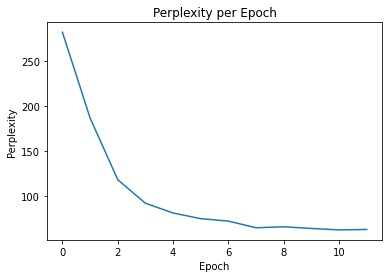

In [ ]:
def plot_perplexity(perplexities):
  """plot perplexities"""
  plt.title("Perplexity per Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Perplexity")
  plt.plot(perplexities)

plot_perplexity(pure_dev_ppls)

Now, let's train the seq2seq model with attention.

Epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch Step: 0 Loss: 144.999466
Epoch Step: 100 Loss: 80.566689
Epoch Step: 200 Loss: 71.372269
Validation perplexity: 94.265278
Epoch 1
Epoch Step: 0 Loss: 66.691887
Epoch Step: 100 Loss: 61.506195
Epoch Step: 200 Loss: 59.452625
Validation perplexity: 57.283866
Epoch 2
Epoch Step: 0 Loss: 57.734486
Epoch Step: 100 Loss: 49.604027
Epoch Step: 200 Loss: 53.692616
Validation perplexity: 45.135871
Epoch 3
Epoch Step: 0 Loss: 52.629532
Epoch Step: 100 Loss: 49.603035
Epoch Step: 200 Loss: 47.753555
Validation perplexity: 38.771326
Epoch 4
Epoch Step: 0 Loss: 49.940273
Epoch Step: 100 Loss: 44.750519
Epoch Step: 200 Loss: 47.932846
Validation perplexity: 39.187900
Epoch 5
Epoch Step: 0 Loss: 42.706295
Epoch Step: 100 Loss: 39.681461
Epoch Step: 200 Loss: 43.184708
Validation perplexity: 38.179853
Epoch 6
Epoch Step: 0 Loss: 34.690266
Epoch Step: 100 Loss: 40.026253
Epoch Step: 200 Loss: 40.850811
Validation perplexity: 35.485375
Epoch 7
Epoch Step: 0 Loss: 38.922245
Epoch Step: 100 Loss: 39

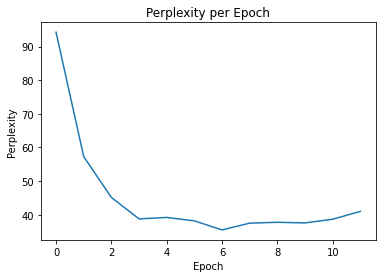

In [ ]:
attention = BahAttention(hidden_size)
attn_seq2seq = EncoderAttentionDecoder(
  encoder=Encoder(embed_size, hidden_size, num_layers, bidirection, dropout),
  decoder=AttentionDecoder(embed_size, hidden_size, attention, num_layers, feed_ratio, dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

attn_dev_ppls = train(attn_seq2seq, num_epochs, learning_rate, 100, clipping_value)

plot_perplexity(attn_dev_ppls)

This is the function used to decode the model output. For simplicity, we use greedy search here.

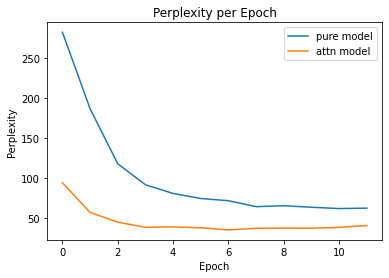

In [ ]:
plt.title("Perplexity per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(pure_dev_ppls, label='pure model')
plt.plot(attn_dev_ppls, label='attn model')
plt.legend(loc = 'upper right')

def greedy_decode(model, src_ids, src_lengths, max_len, pad_index = 0):
  """Greedily decode a sentence for EncoderDecoder."""

  with torch.no_grad():
    encoder_hiddens, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None
  attn_scores = []

  for i in range(max_len):
    with torch.no_grad():
        if model == pure_seq2seq:
            hidden, outputs = model.decode(encoder_finals, prev_y, hidden)
        if model == attn_seq2seq:
            src_mask = (src_ids != pad_index).unsqueeze(1)
            hidden, outputs = model.decode(encoder_finals, encoder_hiddens, prev_y, src_mask, hidden)
            attn_score = model.decoder.attention.att_weight.cpu().numpy()
            attn_scores.append(attn_score)
            
        prob = model.generator(outputs[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)
  attn_scores = np.array(attn_scores)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]

  #print(np.array(attn_scores))
  return output, attn_scores.reshape(max_len, -1)
  

def lookup_words(x, vocab):
  return [vocab[i] for i in x]

Print the top 3 examples from the data loader by applying the greedy decoder.

In [ ]:
def print_examples(model, data_loader, n=5,
                   max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS, 
                   src_vocab_set=src_vocab_set, trg_vocab_set=trg_vocab_set):
  """Prints `n` examples. Assumes batch size of 1."""

  model.eval()

  preds = []
  weights = []

  for i, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
    pred, attn_scores = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                           max_len=max_len)
    
    #preds.append(result)
    #weights.append(attn_scores)

    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]

    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    src_w = lookup_words(src_ids, src_vocab_set)
    #trg_w = lookup_words(trg_ids, trg_vocab_set)
    pred_w = lookup_words(pred, trg_vocab_set)

    print("Example #%d" % (i + 1))
    print("Src : ", " ".join(lookup_words(src_ids, vocab=src_vocab_set)))
    print("Trg : ", " ".join(lookup_words(trg_ids, vocab=trg_vocab_set)))
    print("Pred: ", " ".join(lookup_words(pred, vocab=trg_vocab_set)))
    #print()

    if i == n - 1:
      break
    
  return attn_scores, src_w, pred_w
  

Here we use the validation dataset to print examples.

Example #1
Src :  Cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển .
Trg :  They are both two branches of the same field of atmospheric science .
Pred:  The both is the same of the final challenge in the science science .
Example #2
Src :  Nghiên cứu được viết bởi <unk> nhà khoa học từ 40 quốc gia khác nhau .
Trg :  That report was written by <unk> scientists from 40 countries .
Pred:  So studies studies writing by biologists from <unk> countries .
Example #3
Src :  Mỗi năm , hơn 15,000 nhà khoa học đến San Francisco để tham dự hội nghị này .
Trg :  Over 15,000 scientists go to San Francisco every year for that .
Pred:  Every year , 23 trillion dollars came to San bookstore .
Example #4
Src :  Đó là một lượng khí thải khổng lồ , bằng tổng trọng lượng của <unk> .
Trg :  It &apos;s a huge amount of stuff . It &apos;s equal to the weight of methane .
Pred:  It &apos;s a huge volume of Spain , by the <unk> of the <unk> .
Example #5
Src :  Chính vì lượng khí thải

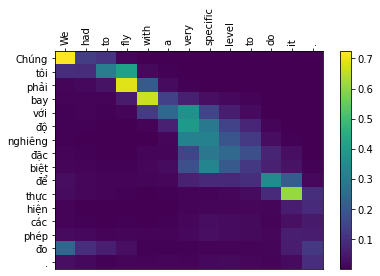

In [ ]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(val_set, batch_size=1, num_workers=1,
                                      shuffle=False)

attn_score, src_w, pred_w = print_examples(attn_seq2seq, example_data_loader, 13, max_sent_length_define)

def attnmap(src, pred, scores):

    fig, ax = plt.subplots()
    att_map = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(pred, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(att_map)
    plt.show()

attnmap(src_w, pred_w, attn_score[:len(src_w), :len(pred_w)])

Compute the BLEU score. BLEU score is a standard measure to evaluate the translation results. For further details, you can refer to [this](https://en.wikipedia.org/wiki/BLEU) link.

In [ ]:
import sacrebleu
from tqdm import tqdm


def compute_BLEU(model, data_loader):
  bleu_score = []

  model.eval()
  for src_ids, src_lengths, trg_ids, _ in tqdm(data_loader):
    result, attn_score = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                           max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    pred = " ".join(lookup_words(result, vocab=trg_vocab_set))
    targ = " ".join(lookup_words(trg_ids, vocab=trg_vocab_set))

    bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score)

  return bleu_score


test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling=1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)

print('BLEU score: %f' % (np.mean(compute_BLEU(pure_seq2seq,
                                               test_data_loader))))
print('BLEU score: %f' % (np.mean(compute_BLEU(attn_seq2seq,
                                               test_data_loader))))

  0%|          | 0/250 [00:00<?, ?it/s]

BLEU score: 4.326025


100%|██████████| 250/250 [00:18<00:00, 13.25it/s]

BLEU score: 10.174215


## **Part 3: Lab writeup**

Your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. In this lab we use greedy search for decoding, that is, always taking the most probable word at current timestep as prediction. Describe an alternative decoding method that might work better than greedy search. You don't have to implement it.

2. Pick some samples from dev or test set and visualize their attention maps. Discuss your findings. Hint: compute the attention scores on the input words for each timestep during decoding.

3. Compare the performance of seq2seq with and without attention on sentences of different lengths. You can set some length intervals (e.g., 1-10, 11-20, 21-30, 31-40, 41-50) and compare the two models' performance within each length interval. Discuss your findings.

4. Try to improve your BLEU score. For example, try stacking more RNN layers, switching cell types, or applying bi-direction to encoder. Describe what you try, even if they don't show improvement. Hints:
  * TA's preliminary implemtation of seq2seq with attention model achieves around 16. You don't have to surpass it (although it's pretty simple to do so)--this number is just to give you some sense of what a baseline should get.
  * Training on the entire training set takes some time. So tune your hyperparameters on a smaller training set (you can do so by changing `sampling` when creating the data loader).